# Parameter estimation with Optax

**Time-series data and optimization with ``optax``**

We create some fake-observational data, compute the marginal likelihood of this fake data _under the ODE posterior_ (which is something you cannot do with non-probabilistic solvers!), and optimize the parameters with `optax`.


Tronarp, Bosch, and Hennig call this "physics-enhanced regression" ([link to paper](https://arxiv.org/abs/2202.01287)).

In [1]:
"""Estimate ODE parameters with ProbDiffEq and Optax."""

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from diffeqzoo import backend, ivps
from jax.config import config

from probdiffeq import ivpsolve
from probdiffeq.impl import impl
from probdiffeq.solvers import solution, uncalibrated
from probdiffeq.solvers.strategies import smoothers
from probdiffeq.solvers.strategies.components import corrections, priors
from probdiffeq.util.doc_util import notebook

In [2]:
plt.rcParams.update(notebook.plot_style())
plt.rcParams.update(notebook.plot_sizes())

In [3]:
if not backend.has_been_selected:
    backend.select("jax")  # ivp examples in jax

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

In [4]:
impl.select("isotropic", ode_shape=(2,))

Create a problem and some fake-data:

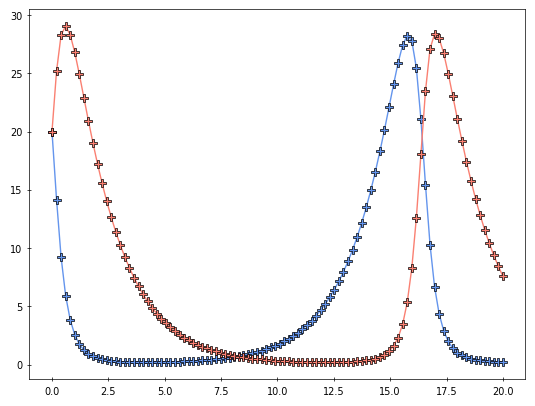

In [5]:
f, u0, (t0, t1), f_args = ivps.lotka_volterra()
f_args = jnp.asarray(f_args)


@jax.jit
def vf(y, t, *, p):  # noqa: ARG001
    """Evaluate the Lotka-Volterra vector field."""
    return f(y, *p)


def solve(p):
    """Evaluate the parameter-to-solution map."""
    ibm = priors.ibm_adaptive(num_derivatives=1)
    ts0 = corrections.ts0()
    strategy = smoothers.smoother_adaptive(ibm, ts0)
    solver = uncalibrated.solver(strategy)

    tcoeffs = (u0, vf(u0, t0, p=p))
    output_scale = 10.0
    init = solver.initial_condition(tcoeffs, output_scale)
    return ivpsolve.solve_fixed_grid(
        lambda y, t: vf(y, t, p=p), init, grid=ts, solver=solver
    )


parameter_true = f_args + 0.05
parameter_guess = f_args


ts = jnp.linspace(t0, t1, endpoint=True, num=100)
solution_true = solve(parameter_true)
data = solution_true.u
plt.plot(ts, data, "P-")
plt.show()

We make an initial guess, but it does not lead to a good data fit:

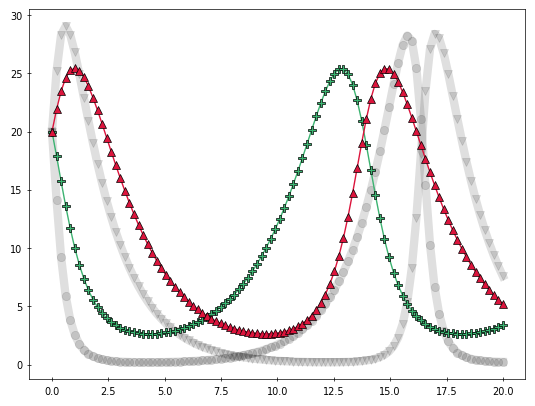

In [6]:
solution_guess = solve(parameter_guess)
plt.plot(ts, data, color="k", linestyle="solid", linewidth=6, alpha=0.125)
plt.plot(ts, solution_guess.u)
plt.show()

Use the probdiffeq functionality to compute a parameter-to-data fit function.

This incorporates the likelihood of the data under the distribution induced by the probabilistic ODE solution (which was generated with the current parameter guess).

In [7]:
@jax.jit
def parameter_to_data_fit(parameters_, /, standard_deviation=1e-1):
    """Evaluate the data fit as a function of the parameters."""
    sol_ = solve(parameters_)
    return -1.0 * solution.log_marginal_likelihood(
        data,
        standard_deviation=jnp.ones_like(sol_.t) * standard_deviation,
        posterior=sol_.posterior,
    )


sensitivities = jax.jit(jax.grad(parameter_to_data_fit))

We can differentiate the function forward- and reverse-mode (the latter is possible because we use fixed steps)

In [8]:
parameter_to_data_fit(parameter_guess)
sensitivities(parameter_guess)

Array([44.61276342, 67.77303453, 51.73918743, 23.0394559 ], dtype=float64)

Now, enter optax: build an optimizer, and optimise the parameter-to-model-fit function. The following is more or less taken from the [optax-documentation](https://optax.readthedocs.io/en/latest/optax-101.html).

In [9]:
def build_update_fn(*, optimizer, loss_fn):
    """Build a function for executing a single step in the optimization."""

    @jax.jit
    def update(params, opt_state):
        """Update the optimiser state."""
        loss, grads = jax.value_and_grad(loss_fn)(params)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state

    return update


optim = optax.adam(learning_rate=1e-2)
update_fn = build_update_fn(optimizer=optim, loss_fn=parameter_to_data_fit)

In [10]:
p = parameter_guess
state = optim.init(p)

chunk_size = 10
for i in range(chunk_size):
    for _ in range(chunk_size):
        p, state = update_fn(p, state)

    print(f"After {(i+1)*chunk_size} iterations:", p)

After 10 iterations: [0.42794484 0.0431105  0.42448496 0.05164625]
After 20 iterations: [0.45761997 0.07930843 0.45718313 0.04100026]
After 30 iterations: [0.47889407 0.07980121 0.47683647 0.05482259]
After 40 iterations: [0.49760343 0.07805364 0.49369539 0.06954601]
After 50 iterations: [0.51323164 0.08077862 0.50876274 0.07999556]
After 60 iterations: [0.52519905 0.08671969 0.52114674 0.08657673]
After 70 iterations: [0.53450347 0.0920097  0.53107724 0.09048173]
After 80 iterations: [0.54103546 0.09547625 0.53797195 0.09362367]
After 90 iterations: [0.54536711 0.09734236 0.54241532 0.09625808]
After 100 iterations: [0.54811312 0.09840084 0.54520017 0.09811054]


The solution looks much better:

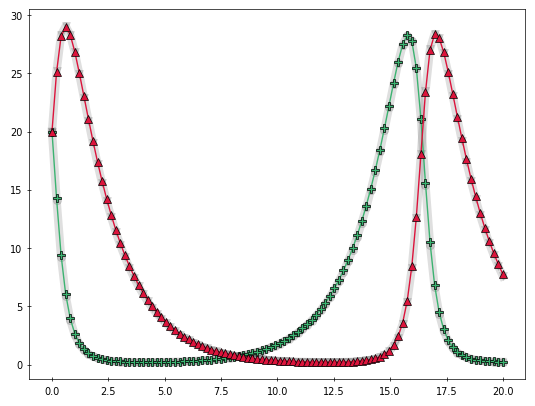

In [11]:
solution_better = solve(p)
plt.plot(ts, data, color="k", linestyle="solid", linewidth=6, alpha=0.125)
plt.plot(ts, solution_better.u)
plt.show()